In [4]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('anime_model.h5')

In [5]:
import pickle

with open('processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

rating_df = data["rating_df"]
user2user_encoded = data["user2user_encoded"]
user_encoded2user = data["user_encoded2user"]
anime2anime_encoded = data["anime2anime_encoded"]
anime_encoded2anime = data["anime_encoded2anime"]

In [6]:
import numpy as np
import pandas as pd

def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights
    
anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [7]:
import os

INPUT_DIR = './Anime Dataset'
df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)
df = df.replace("Unknown", np.nan)

In [8]:
# Fixing Names
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('error')
    
    return name

df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

df.sort_values(by=['Score'], 
               inplace=True,
               ascending=False, 
               kind='quicksort',
               na_position='last')

df = df[["anime_id", "eng_version", 
         "Score", "Genres", "Episodes", 
         "Type", "Premiered", "Members"]]

In [9]:
def getAnimeFrame(anime):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [10]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
sypnopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', usecols=cols)

def getSypnopsis(anime):
    if isinstance(anime, int):
        return sypnopsis_df[sypnopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return sypnopsis_df[sypnopsis_df.Name == anime].sypnopsis.values[0]

# Predcitions: 

In [11]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest
        
        rindex = df

        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            sypnopsis = getSypnopsis(decoded_id)
            anime_frame = getAnimeFrame(decoded_id)
            
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                  "similarity": similarity,"genre": genre,
                                  'sypnopsis': sypnopsis})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))

In [12]:
#Main Function to predict
find_similar_animes('Dragon Ball Z', n=5, neg=False)

animes closest to Dragon Ball Z


,name,similarity,genre,sypnopsis
4,Dragon Ball,0.978580,"Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power","Gokuu Son is a young boy who lives in the woods all alone—that is, until a girl named Bulma runs into him in her search for a set of magical objects called the ""Dragon Balls."" Since the artifacts are said to grant one wish to whoever collects all seven, Bulma hopes to gather them and wish for a perfect boyfriend. Gokuu happens to be in possession of a dragon ball, but unfortunately for Bulma, he refuses to part ways with it, so she makes him a deal: he can tag along on her journey if he lets her borrow the dragon ball's power. With that, the two set off on the journey of a lifetime. They don't go on the journey alone. On the way, they meet the old Muten-Roshi and wannabe disciple Kuririn, with whom Gokuu trains to become a stronger martial artist for the upcoming World Martial Arts Tournament. However, it's not all fun and games; the ability to make any wish come true is a powerful one, and there are others who would do much worse than just wishing for a boyfriend. To stop those who would try to abuse the legendary power, they train to become stronger fighters, using their newfound strength to help the people around them along the way."
3,Dragon Ball GT,0.923025,"Action, Sci-Fi, Adventure, Comedy, Super Power, Magic, Fantasy, Shounen","Emperor Pilaf finally has his hands on the Black Star Dragon Balls after years of searching, which are said to be twice as powerful as Earth's normal ones. Pilaf is about to make his wish for world domination when he is interrupted by Gokuu Son. As a result, Pilaf flubs his wish and accidentally turns Gokuu back into a child. After the wish is granted, the Black Star Dragon Balls scatter across the galaxy. However, Gokuu discovers that they will cause the Earth to explode unless they are all brought back within a year. Uniting with his granddaughter Pan and a young adult Trunks, Gokuu sets off on an adventure through the universe to find the Black Star Dragon Balls and save his planet from destruction."
2,Dragon Ball Z Kai,0.820054,"Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power","Five years after the events of Dragon Ball, martial arts expert Gokuu is now a grown man married to his wife Chi-Chi, with a four-year old son named Gohan. While attending a reunion on Turtle Island with his old friends Master Roshi, Krillin, Bulma and others, the festivities are interrupted when a humanoid alien named Raditz not only reveals the truth behind Gokuu's past, but kidnaps Gohan as well. With Raditz displaying power beyond anything Gokuu has seen before, he is forced to team up with his old nemesis, Piccolo, in order to rescue his son. But when Gokuu and Piccolo reveal the secret of the seven mystical wish-granting Dragon Balls to Raditz, he informs the duo that there is more of his race, the Saiyans, and they won’t pass up an opportunity to seize the power of the Dragon Balls for themselves. These events begin the saga of Dragon Ball Kai , a story that finds Gokuu and his friends and family constantly defending the galaxy from increasingly more powerful threats. Bizarre, comical, heartwarming and threatening characters come together in a series of battles that push the powers and abilities of Gokuu and his friends beyond anything they have ever experienced."
1,Naruto,0.797569,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen","oments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning de

# Finding Similar Users (User Based Recommendation)

In [13]:
print('> picking up random user')

ratings_per_user = rating_df.groupby('user_id').size()
random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0]
print('> user_id:', random_user)

> picking up random user
> user_id: 105406


In [14]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weights = user_weights
    
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest
        
        rindex = df
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        
        return Frame
    
    except:
        print('{}!, Not Found in User list'.format(name))

In [15]:
similar_users = find_similar_users(int(random_user), 
                                   n=5, 
                                   neg=False)

similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users.head(5)

> users similar to #105406


,similar_users,similarity
4,233350,0.825885
3,258332,0.824278
2,181863,0.822288
1,261492,0.821507
0,253949,0.820639


In [16]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, 
                             background_color='white', 
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(10,8)) 
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        
        genres_list = []
        for genres in frame['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1    
        if plot:
            showWordCloud(all_genres)
        
        return genres_list

    
def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = rating_df[rating_df.user_id==user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)#.head(10)
        .anime_id.values
    )
    
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]
    
    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          user_id, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))
    
        print('> preferred genres')
    
    if plot:
        getFavGenre(anime_df_rows, plot)
        
    return anime_df_rows#.eng_version.values

> User #105406 has rated 497 movies (avg. rating = 0.0)
> preferred genres


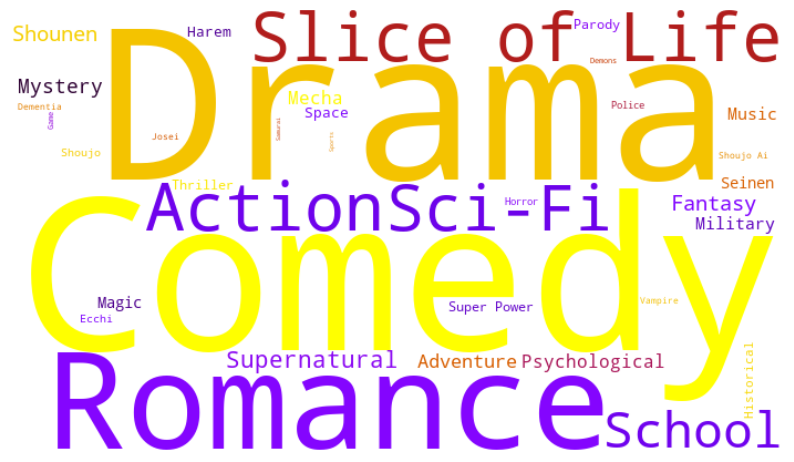

> animes highly rated by this user


,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
9886,A Silent Voice,"Drama, School, Shounen"


In [17]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(5)

In [18]:
def get_recommended_animes(similar_users, n=10):
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), verbose=0)
        pref_list = pref_list[~ pref_list.eng_version.isin(user_pref.eng_version.values)]
        anime_list.append(pref_list.eng_version.values)
        
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    
    for i, anime_name in enumerate(sorted_list.index):        
        n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
        if isinstance(anime_name, str):
            try:
                frame = getAnimeFrame(anime_name)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                sypnopsis = getSypnopsis(int(anime_id))
                recommended_animes.append({#"anime_id": anime_id ,
                                            "n": n_user_pref,
                                            "anime_name": anime_name, 
                                            "Genres": genre, 
                                            "sypnopsis": sypnopsis})
            except:
                pass
    
    return pd.DataFrame(recommended_animes)

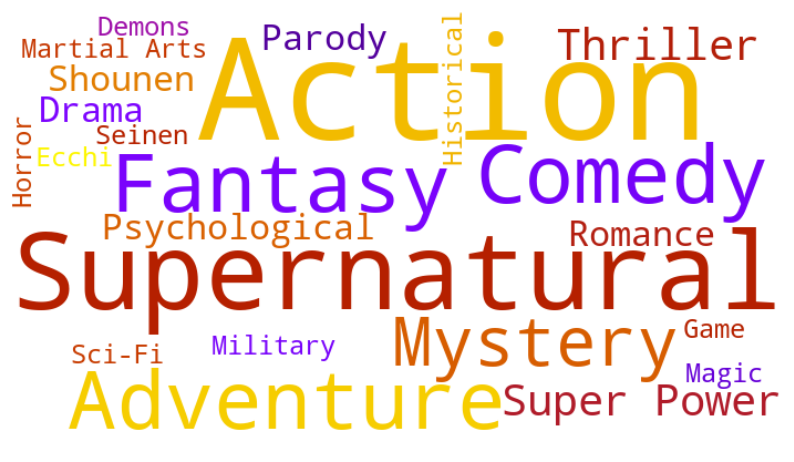


> Top recommendations for user: 105406


,n,anime_name,Genres,sypnopsis
0,7,GATE,"Action, Military, Adventure, Fantasy","Several months have passed since the infamous Ginza Incident, with tensions between the Empire and JSDF escalating in the vast and mysterious ""Special Region"" over peace negotiations. The greed and curiosity of the global powers have also begun to grow, as reports about the technological limitations of the magical realm's archaic civilizations come to light. Meanwhile, Lieutenant Youji Itami and his merry band of female admirers struggle to navigate the complex political intrigue that plagues the Empire's court. Despite her best efforts, Princess Piña Co Lada faces difficulties attempting to convince her father that the JSDF has no intention of conquering their kingdom. Pressured from both sides of the Gate, Itami must consider even more drastic measures to fulfill his mission."
1,5,"No Game, No Life","Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy","No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username ""Blank."" They view the real world as just another lousy game; however, a strange e-mail challenging them to a chess match changes everything—the brother and sister are plunged into an otherworldly realm where they meet Tet, the God of Games. The mysterious god welcomes Sora and Shiro to Disboard, a world where all forms of conflict—from petty squabbles to the fate of whole countries—are settled not through war, but by way of high-stake games. This system works thanks to a fundamental rule wherein each party must wager something they deem to be of equal value to the other party's wager. In this strange land where the very idea of humanity is reduced to child's play, the indifferent genius gamer duo of Sora and Shiro have finally found a real reason to keep playing games: to unite the sixteen races of Disboard, defeat Tet, and become the gods of this new, gaming-is-everything world."
2,5,[C] CONTROL - The Money and Soul of Possibility,"Action, Mystery, Super Power, Thriller","oney is power, and without it, life is meaningless. In a country whose economy is in shambles, second-year Economics university student Kimimaro Yoga understands this fact all too well, as he is surrounded by the relatively luxurious lives of his peers and struggling to make ends meet. However, his world is turned on its head when a stranger in a top hat arrives one late night at his door. Going by the name Masakaki, the visitor petitions Yoga to come to the Eastern Financial District, a place where money flows in abundance if one offers their ""future"" as collateral. Although reluctant, greed triumphs reason and Yoga accepts the offer; thus, taking on the mantle of an ""Entre."" But unbeknownst to him, the land of wealth he has entered is an alternate realm built in the likeness of his own, where Entres are forced to participate in weekly duels called ""Deals,"" with their collateral at stake. Pitted against his countrymen and fate, Yoga must quickly adapt in this new world if he hopes to protect his fortune and future—and discover just how much money is truly worth."
3,5,Puella Magi Madoka Magica,"Psychological, Drama, Magic, Thriller","adoka Kaname and Sayaka Miki are regular middle school girls with regular lives, but all that changes when they encounter Kyuubey, a cat-like magical familiar, and Homura Akemi, the new transfer student. Kyuubey offers them a proposition: he will grant any one of their wishes and in exchange, they will each become a magical girl, gaining enough power to fulfill their dreams. However, Homura Akemi, a magical girl herself, urges them not to accept the offer, stating that everything is not what it seems. A story of hope, despair, and friendship, Mahou Shoujo Madoka★Magica deals with the difficulties of being a magical girl and the price one has to pay to make a dream come true."
4,5,Elfen Lied,"Action, Horror, Psychological, Supernatural, Drama, Roma

In [19]:
recommended_animes = get_recommended_animes(similar_users, n=10)
getFavGenre(recommended_animes, plot=True)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes

In [20]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id==random_user]
anime_not_watched_df = df[
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(random_user)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])
    
    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.anime_id == id_)
            name = df[condition]['eng_version'].values[0]
            genre = df[condition].Genres.values[0]
            score = df[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue
            
        Results.append({#"anime_id": id_, 
                        "name": name, 
                        "pred_rating": rating,
                        "genre": genre, 
                        'sypnopsis': sypnopsis})

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)


Results = pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)
Results

Showing recommendations for user: 105406
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


,name,pred_rating,genre,sypnopsis
7,Mieruko-chan,0.866376,"Comedy, Horror, Supernatural","ko is a typical high school student whose life turns upside down when she suddenly starts to see gruesome and hideous monsters. Despite being completely terrified, Miko carries on with her daily life, pretending not to notice the horrors that surround her. She must endure the fear in order to keep herself and her friend Hana out of danger, even if that means coming face to face with the absolute worst. Blending both comedy and horror, Mieruko-chan tells the story of a girl who tries to deal with the paranormal by acting indifferent toward it."
4,Kyoukai Senki,0.800420,"Action, Mecha","In the year 2061 AD, Japan has lost its sovereignty. The Japanese people spend their days as oppressed citizens after being divided and ruled by the four major trade factions. The country became the forefront of the world following the deployment of AMAIM—a humanoid special mobile weapon—by each economic bloc. One day, Amou Shiiba, a boy who loves machines, meets Gai, an autonomous thinking A.I. The encounter leads Amou to cast himself into the battle to reclaim Japan, piloting the AMAIM Kenbu that he built himself. (Source: MAL News)"
6,Daomu Biji Zhi Qinling Shen Shu,0.787384,"Adventure, Mystery, Supernatural",No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
5,Tsuki to Laika to Nosferatu,0.781991,"Sci-Fi, Space, Vampire","The first astronaut in human history was a vampire girl. Following the end of World War II, the world-dividing superpowers, Federal Republic of Zirnitra in the East and United Kingdom of Arnack in the West, turned their territorial ambitions toward space. Both countries have been competing fiercely for development. East history 1960. Gergiev, the chief leader of the Republic, announces the manned space flight program Project Mechtat (Dream), which, if successful, would be the first feat for humankind. At that time, Lev Leps, a substitute astronaut candidate, is ordered to perform a top secret mission. The ""Nosferatu Project""—a program that experiments with vampires prior to manned missions—will use Irina Luminesk as a test subject, and Lev is to monitor and train her. Even while trifled by the walls of the race and ego of the nations, Lev and Irina share a genuine sentiment as they aim for the universe. (Source: MAL News)"
8,Macross Δ Movie 2: Zettai Live!!!,0.757704,"Action, Military, Sci-Fi, Music, Space, Mecha","alküre and Delta Flight used music to save people from the Vár Syndrome, a previously unknown disease that made humans and others go berserk. However, they find themselves facing a new threat… (Source: ANN)"
2,BanG Dream! Film Live 2nd Stage,0.750873,Music,No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
9,Mobile Suit Gundam: Hathaway's Flash 2,0.745308,"Action, Military, Sci-Fi, Space, Drama, Mecha",No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
1,No Doubt In Us,0.740152,"Comedy, Fantasy, Historical, Romance","His Majesty comes close so handsome that flushed queen pushes him reflexively and falls with him together into the pool. Then they swap their bodies. The way to swap back is unknown. The most important thing is that the emperor is quite angry now!! Before every comes to normal, emperor has to deal with his mean imperial concubines that he never knows and the queen has to mediate between those ministeries... (Source: Webnovel)"
0,Mahoutsukai ni Narenakatta Onnanoko no Hanashi.,0.735050,"Drama, Fantasy, Magic, School, Slice of Life","Kurumi Mirai is in the first year of high school. She has enrolled in junior high section of the Redrun Magic School, the world's only facility for mages that approved by International Mage League and able to work under royal families when graduates, and she was always top of the class. However, when she applies for